In [1]:
import numpy as np
from scipy.special import erf, erfinv
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

In [2]:
NE, NI, N_syl, N_HVC_per_syl = 600, 150, 1, 1
N_HVC = N_syl * N_HVC_per_syl

In [3]:
peak_rate, kernel_width = 150, 50

In [4]:
T_rend = kernel_width # Each rendition
N_rend = 100 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

In [5]:
# Syllables and time stamps
# ( Number of syllables , Number of renditions )
_ = np.arange(0, T - T_burn + T_rend, T_rend) # start and end time of each rendition
# start and end time of each syllabus; inter-rendition interval = duration of a syllabus
_ = np.linspace(_[:-1], _[1:], num=N_syl+1, endpoint=True) + T_burn
tsyl_start, tsyl_end = _[:-1], _[1:]
tsyl_start, tsyl_end = np.round(tsyl_start), np.round(tsyl_end)

syl = rng.normal(1, 2, size=(N_syl, NE))#.clip(min=0)
syl_rand = syl.copy()
rng.shuffle(syl_rand, axis=1)
save_W_ts = np.round(tsyl_end[-1,:-1]).astype(int)

In [6]:
rH = np.zeros((T, N_HVC))
for i in range(N_HVC):
    bt = (tsyl_start[0] + i * kernel_width).astype(int)
    for b in bt:
        rH[b:b+kernel_width,i] = peak_rate

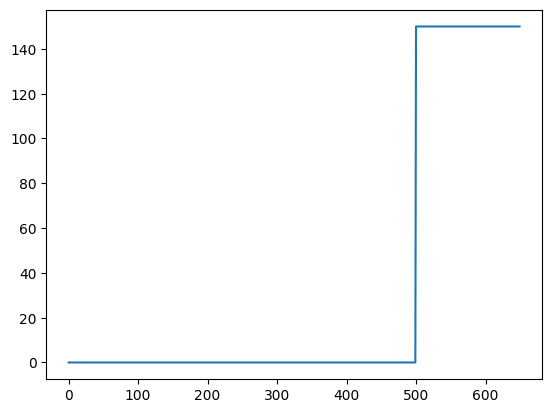

In [7]:
plt.plot(rH[:T_burn+T_rend*3])

In [8]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
# aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

In [9]:
def test_EI(net, HVC_idx, T_test=2000, dt=1):
    T_burn = T_test // 2
    names = ['Singing (Ctrl)', 'Singing (Perturb.)', 'Playback', 'Deaf']
    ret = dict()
    
    for i, n in enumerate(names):
        rE = np.zeros((T_test, net.NE))
        rI = np.zeros((T_test, net.NI))
        hE, hI = rE.copy(), rI.copy()
        rE[0] = rng.normal(loc=1, scale=0.5, size=net.NE).clip(min=0)
        rI[0] = rng.normal(loc=5, scale=0.5, size=net.NI).clip(min=0)
        rH, aud = np.zeros((T_test, net.NH)), np.zeros((T_test, net.NE))
        if i == 0:
            rH[T_burn:] = peak_rate
            aud[T_burn:] = syl[0]
        elif i == 1:
            rH[T_burn:] = peak_rate
            aud[T_burn:] = syl_rand[0]
        elif i == 2:
            aud[T_burn:] = syl[0]
        elif i == 3:
            rH[T_burn:] = peak_rate
    
        for t in tqdm(range(1, T_test)):
            aux = net.W @ rH[t-1] - net.w_inh * rH[t-1].sum()
            hE[t-1] = net.JEE @ rE[t-1] - net.JEI @ rI[t-1]
            hI[t-1] = net.JIE @ rE[t-1] - net.JII @ rI[t-1]
            dI = -rI[t-1] + net.phiI(hI[t-1] + net.wI * rH[t-1].mean())
            rI[t] = rI[t-1] + dI * dt / net.tauI
            drE = -rE[t-1] + net.phiE(aux + aud[t-1] + hE[t-1])
            rE[t] = rE[t-1] + drE * dt / net.tauE
        aux = dict(rE=rE, rI=rI, hE=hE, hI=hI, rH=rH, aud=aud)
        ret[n] = aux
    return ret

In [10]:
def plot_rates(rE_pre, rE_post, rI_pre, rI_post, dt=10, n_samples=4):
    # For better visualization
    ts = np.arange(0, rE_pre.shape[0], step=dt)
    
    fig, ax = plt.subplots(3, 2, figsize=(4, 5), sharex='all', sharey='row')
    ax[0,0].plot(ts, rE_pre[::dt].mean(axis=1), color='r', label='E')
    ax[0,0].plot(ts, rI_pre[::dt].mean(axis=1), color='b', label='I')
    ax[0,1].plot(ts, rE_post[::dt].mean(axis=1), color='r', label='E')
    ax[0,1].plot(ts, rI_post[::dt].mean(axis=1), color='b', label='I')
    ax[0,0].set(ylabel='Mean rate (Hz)', title='Before learning')
    ax[0,1].set(ylim=[0, ax[0,1].get_ylim()[1]], title='After learning')
    ax[0,0].legend(ncols=1, fontsize='small', frameon=True, loc='upper left')

    cmap1, cmap2 = plt.get_cmap('autumn'), plt.get_cmap('winter')
    for i in range(n_samples):
        # j, k = i, i
        j, k = rng.integers(0, NE), rng.integers(0, NI)
        ax[1,0].plot(ts, rE_pre[::dt,j], color=cmap1(i/n_samples), lw=1)
        ax[2,0].plot(ts, rI_pre[::dt,k], color=cmap2(i/n_samples), lw=1)
        ax[1,1].plot(ts, rE_post[::dt,j], color=cmap1(i/n_samples), lw=1)
        ax[2,1].plot(ts, rI_post[::dt,k], color=cmap2(i/n_samples), lw=1)
    ax[1,0].set(ylabel='Exc. rate (Hz)')
    ax[2,0].set(xlabel='Time (a.u.)', ylabel='Inh. rate (Hz)')
    fig.tight_layout(pad=0.1)
    return fig, ax

In [11]:
lr, tauW = -1e-1, 1e5
rEmax, rImax, thE, thI, sE, sI = 40, 100, -5, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

def quick_net(gamma, w0_mean, w_inh, 
              JEE0=1, JEI0=0.8, JIE0=1.25, JII0=0.9, wI=0, tauE=40, tauI=10):
    gen = lognormal_gen
    # gen = const_gen
    c = 1
    sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * gamma
    # sEE *= 1.3
    JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE) / np.sqrt(NE)
    JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI) / np.sqrt(NI)
    JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE) / np.sqrt(NE)
    JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII) / np.sqrt(NI)

    net = EINet(NE, NI, N_HVC, w0_mean, phiE, phiI, tauE, tauI, w0_std=w0_mean/2,
                JEE=JEE, JEI=JEI, JIE=JIE, JII=JII, w_inh=w_inh, wI=wI)
    return net

In [12]:
def bilin_hebb(net, aiv, hvc, lr, w0_mean, tauW):
    # lr < 0, anti-Hebbian
    for i, h in enumerate(hvc):
        dW = lr * (aiv - 1) * h - (net.W[:,i] - w0_mean)
        net.W[:,i] = np.clip(net.W[:,i] + dW / tauW, a_min=0, a_max=None)
        # net.W[:,i] = net.W[:,i] + dW / tauW

In [13]:
w0_mean = 0.1/N_HVC
w_inh = w0_mean
net_fp = quick_net(0.2, w0_mean, w_inh)
net_lc = quick_net(0.3, w0_mean, w_inh)

In [14]:
fp_pre = test_EI(net_fp, [0])

rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
dt = 1
train_fp = net_fp.sim(rE0, rI0, rH, aud, save_W_ts, T, dt, 0, bilin_hebb,
                      lr=lr, w0_mean=w0_mean, tauW=tauW)

fp_post = test_EI(net_fp, [0])

100%|█████████████████████████████████████| 1999/1999 [00:00<00:00, 4724.64it/s]


In [15]:
lc_pre = test_EI(net_lc, [0])

rE0 = rng.normal(loc=1, scale=0.5, size=NE).clip(min=0)
rI0 = rng.normal(loc=5, scale=0.5, size=NI).clip(min=0)
dt = 1
train_lc = net_lc.sim(rE0, rI0, rH, aud, save_W_ts, T, dt, 0, bilin_hebb,
                      lr=lr, w0_mean=w0_mean, tauW=tauW)

lc_post = test_EI(net_lc, [0])

100%|█████████████████████████████████████| 1999/1999 [00:00<00:00, 5883.58it/s]


Model: complete natural alg
What trying to do/understand? Secret sause?
People focus a lot on RL but not how calc 

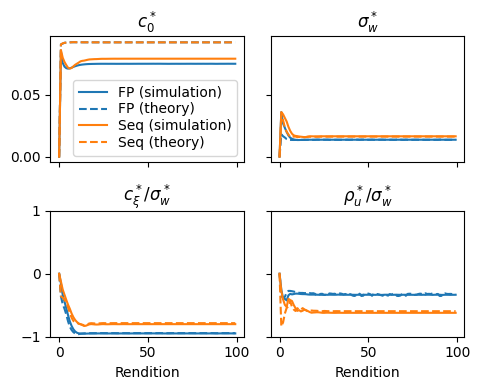

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(5, 4), sharex='all', sharey='row')

ti = int(tsyl_start[0,0]) # when to start

for k, (tr, l) in enumerate(zip((train_fp, train_lc), ('FP', 'Seq'))):
    c0_lhs, c0_rhs = [0], [0]
    sig_w_lhs, sig_w_rhs = [0], [0]
    corr_u_lhs, corr_u_rhs = [0], [0]
    corr_xi_lhs, corr_xi_rhs = [0], [0]
    for i, W in enumerate(tr[2][1:]):
        t_star = int(tsyl_end[0,i] - 5 - 1) # the last of tsyl_end is len so -1
        sig = tr[-1][t_star].std() # noise std at t*
        
        # c0: W mean
        ti, tj = int(tsyl_start[0,i]), int(tsyl_end[0,i])
        rE_mean = tr[0][ti:tj].mean()
        d0 = np.sqrt(2 * np.pi) * sE * (1 - rE_mean) / rEmax
        c0_lhs.append(W.mean())
        c0_rhs.append((d0 - syl.mean()) / peak_rate + w_inh)

        # sig_w: W std
        sig_w_lhs.append(W.std())
        # sig_w_rhs.append(np.sqrt((sig / peak_rate)**2 + c_xi**2))
        sig_w_rhs.append(np.sqrt(sig**2 + syl.var()) / peak_rate)
    
        # corr between W(t*) and (normalized) xi
        corr_xi_lhs.append(correlation(syl[0], W.T)[0])
        corr_xi_rhs.append(-syl[0].std() / W.std() / peak_rate)
        
        # corr between W(t*) and epsilon(t*)
        corr_u_lhs.append(correlation(tr[-1][t_star], W[:,0], dim=1))
        corr_u_rhs.append((-sig / W.std() / peak_rate).mean())

    color, l1, l2 = 'C%d' % k, l + ' (simulation)', l + ' (theory)'
    ax[0,0].plot(c0_lhs, c=color, label=l1)
    ax[0,0].plot(c0_rhs, c=color, ls='--', label=l2)
    ax[0,1].plot(sig_w_lhs, c=color, label=l1)
    ax[0,1].plot(sig_w_rhs, c=color, ls='--', label=l2)
    ax[1,0].plot(corr_xi_lhs, c=color, label=l1)
    ax[1,0].plot(corr_xi_rhs, c=color, ls='--', label=l2)
    ax[1,1].plot(corr_u_lhs, c=color, label=l1)
    ax[1,1].plot(corr_u_rhs, c=color, ls='--', label=l2)
    
ax[1,0].set(ylim=[-1, 1], xlabel='Rendition', yticks=[-1, 0, 1])
ax[1,1].set(xlabel='Rendition')
ax[0,0].set_title(r'$c^*_0$')
ax[0,1].set_title(r'$\sigma^*_w$')
ax[1,0].set_title(r'$c^*_\xi / \sigma^*_w$')
ax[1,1].set_title(r'$\rho^*_u / \sigma^*_w$') 
ax[0,0].legend(labelspacing=0.2)
fig.tight_layout()

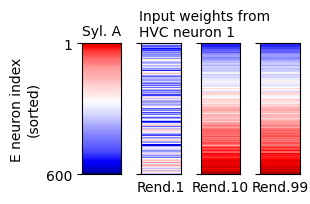

In [17]:
fig, ax = plot_example_colW_syl(train_fp[2], syl[0], 0, [1, 10, len(train_fp[2])-1])

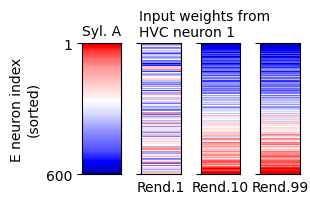

In [18]:
fig, ax = plot_example_colW_syl(train_lc[2], syl[0], 0, [1, 10, len(train_lc[2])-1])

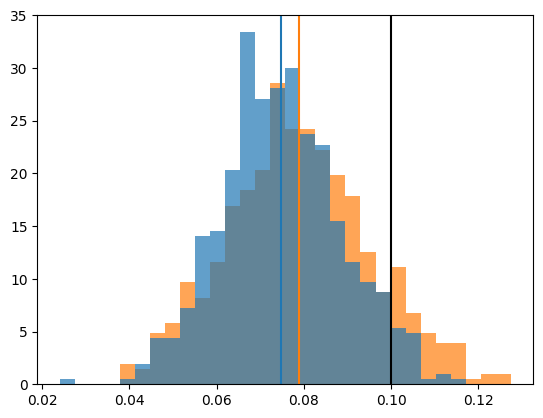

In [19]:
plt.hist([train_fp[2][-1].flatten(), train_lc[2][-1].flatten()], 
         density=True, bins=30, histtype='stepfilled', alpha=0.7)
plt.axvline(train_fp[2][-1].mean(), color='C0')
plt.axvline(train_lc[2][-1].mean(), color='C1')
plt.axvline(w0_mean, color='k')

In [20]:
def plot_sig_E(pre, post):
    fig, ax = plt.subplots(1, figsize=(4, 3))
    T = np.where(pre['Singing (Ctrl)']['rH'][:,0] > 0)[0][0]
    spon = pre['Singing (Ctrl)']['hE'][:T].std(axis=1).mean()
    ax.axhline(spon, color='k', ls=':', label='Spontaneous')
    width = 1 / (len(pre.keys()) + 1)
    for i, k in enumerate(pre.keys()):
        j = (i - len(pre.keys())//2) * width
        y = [pre[k]['hE'][T:-1].std(axis=1).mean(), 
             post[k]['hE'][T:-1].std(axis=1).mean()]
        yerr = [pre[k]['hE'][T:-1].std(axis=1).std(), 
                post[k]['hE'][T:-1].std(axis=1).std()]
        ax.bar([j, 1+j], y, yerr=yerr, width=width, label=k, align='edge')
    handles, labels = ax.get_legend_handles_labels() # Put spon in a single row
    ax.legend([*handles[1:3], handles[0], *handles[3:]], 
              [*labels[1:3], labels[0], *labels[3:]], 
              ncol=2, loc=[0, 1], frameon=False)
    ax.set(xticks=[0, 1], xticklabels=['Before Learning', 'After Learning'],
           ylabel='Intrinsic noise std')
    return fig, ax

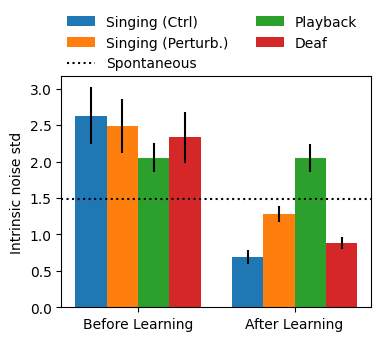

In [21]:
plot_sig_E(fp_pre, fp_post);

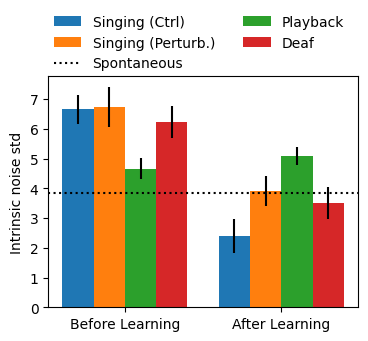

In [22]:
plot_sig_E(lc_pre, lc_post);

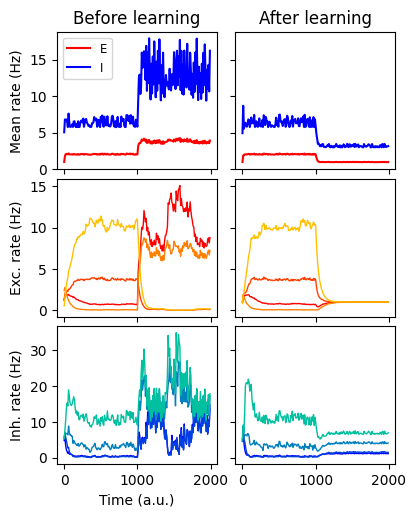

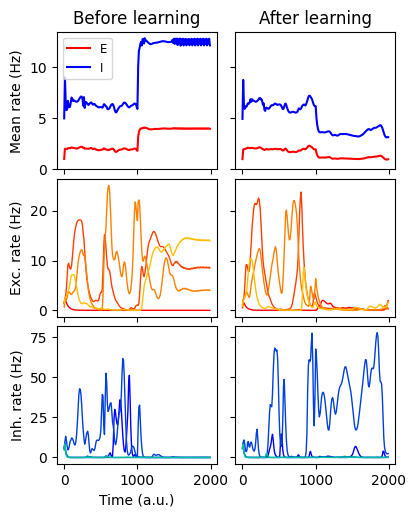

In [23]:
k = 'Singing (Ctrl)'
fig, ax = plot_rates(fp_pre[k]['rE'], fp_post[k]['rE'], fp_pre[k]['rI'], fp_post[k]['rI'])
fig, ax = plot_rates(lc_pre[k]['rE'], lc_post[k]['rE'], lc_pre[k]['rI'], lc_post[k]['rI'])

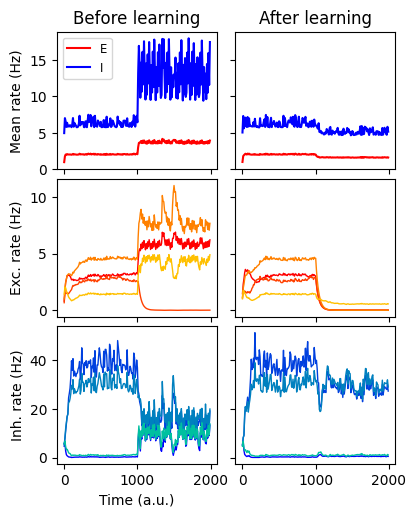

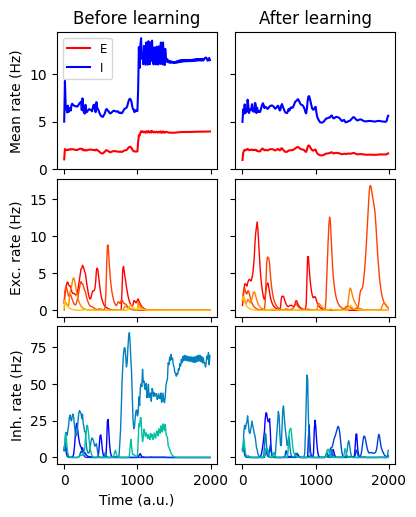

In [24]:
k = 'Singing (Perturb.)'
fig, ax = plot_rates(fp_pre[k]['rE'], fp_post[k]['rE'], fp_pre[k]['rI'], fp_post[k]['rI'])
fig, ax = plot_rates(lc_pre[k]['rE'], lc_post[k]['rE'], lc_pre[k]['rI'], lc_post[k]['rI'])

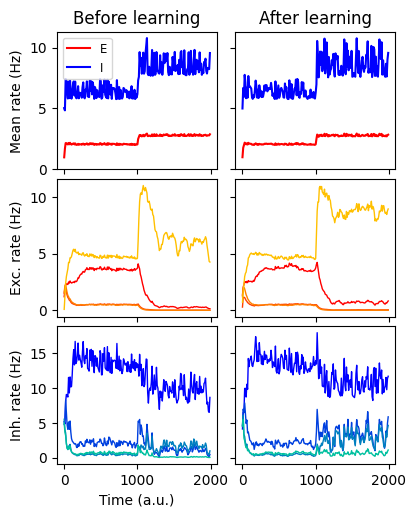

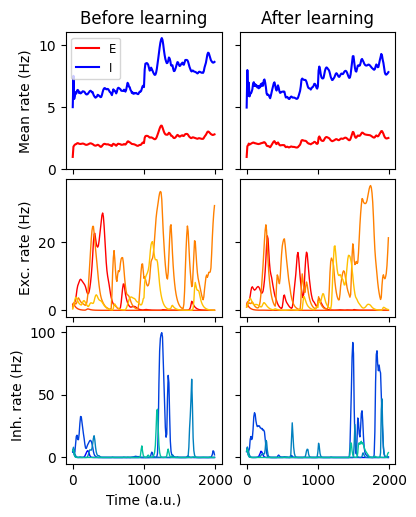

In [25]:
k = 'Playback'
fig, ax = plot_rates(fp_pre[k]['rE'], fp_post[k]['rE'], fp_pre[k]['rI'], fp_post[k]['rI'])
fig, ax = plot_rates(lc_pre[k]['rE'], lc_post[k]['rE'], lc_pre[k]['rI'], lc_post[k]['rI'])

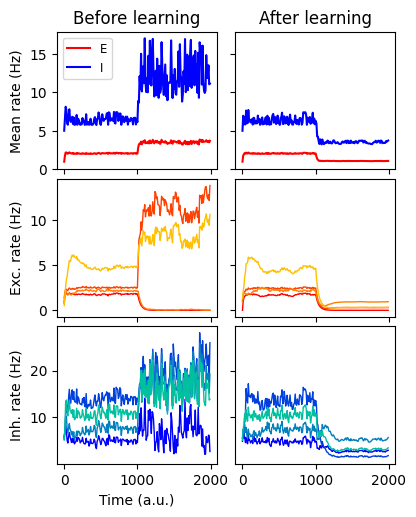

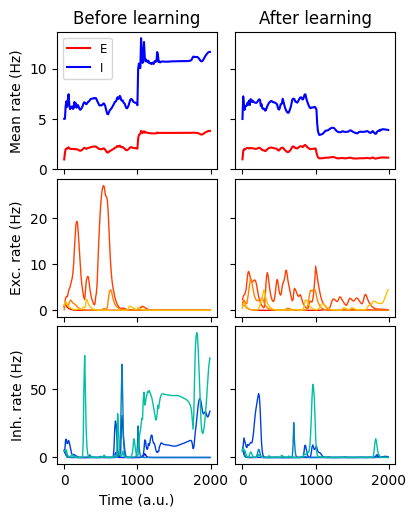

In [26]:
k = 'Deaf'
fig, ax = plot_rates(fp_pre[k]['rE'], fp_post[k]['rE'], fp_pre[k]['rI'], fp_post[k]['rI'])
fig, ax = plot_rates(lc_pre[k]['rE'], lc_post[k]['rE'], lc_pre[k]['rI'], lc_post[k]['rI'])